In [28]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical
import seaborn as sns

import numpy as np

In [29]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial_Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/takea/Desktop/DeepLearning/datasets/week3/HAR_Dataset/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/takea/Desktop/DeepLearning/datasets/week3/HAR_Dataset/UCI_HAR_Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [30]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [31]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

In [32]:
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [33]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [34]:
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [37]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical

In [38]:
##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1) 
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


##Level_3
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
# layer 4

conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2) 
# merge2
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)

#maxpool2
pool_3=MaxPooling1D(pool_size=5)(merged_3)


#flatten
flat_cnn=Flatten()(pool_3)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                              

In [40]:
# fit network
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_data= ([testX,testX,testX,testX],testy_one_hot))

Epoch 1/30
184/184 [==============================] - 36s 162ms/step - loss: 0.2898 - accuracy: 0.8874 - val_loss: 0.2834 - val_accuracy: 0.8965
Epoch 2/30
184/184 [==============================] - 31s 168ms/step - loss: 0.1131 - accuracy: 0.9517 - val_loss: 0.2545 - val_accuracy: 0.9267
Epoch 3/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1041 - accuracy: 0.9548 - val_loss: 0.2835 - val_accuracy: 0.9026
Epoch 4/30
184/184 [==============================] - 28s 150ms/step - loss: 0.0966 - accuracy: 0.9602 - val_loss: 0.2604 - val_accuracy: 0.9063
Epoch 5/30
184/184 [==============================] - 31s 171ms/step - loss: 0.1320 - accuracy: 0.9524 - val_loss: 0.4023 - val_accuracy: 0.8680
Epoch 6/30
184/184 [==============================] - 28s 152ms/step - loss: 0.1082 - accuracy: 0.9546 - val_loss: 0.2599 - val_accuracy: 0.9152
Epoch 7/30
184/184 [==============================] - 29s 158ms/step - loss: 0.0953 - accuracy: 0.9580 - val_loss: 0.2944 - val_ac

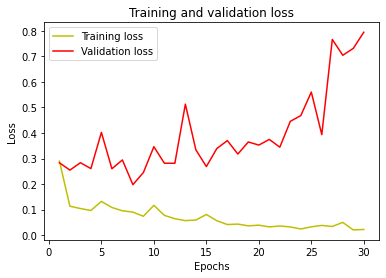

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

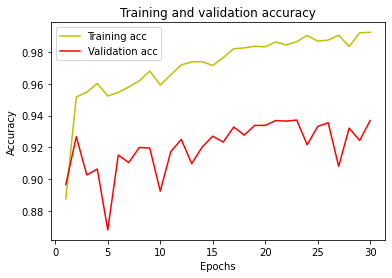

In [42]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 [==============================] - 4s 35ms/step
[[468   1  26   0   1   0]
 [  4 446  19   2   0   0]
 [  0   0 420   0   0   0]
 [  0   2   0 418  71   0]
 [  0   0   0  33 499   0]
 [  0   0   0   0  27 510]]
0.9368849677638276
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       496
           1       0.99      0.95      0.97       471
           2       0.90      1.00      0.95       420
           3       0.92      0.85      0.89       491
           4       0.83      0.94      0.88       532
           5       1.00      0.95      0.97       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<AxesSubplot:>

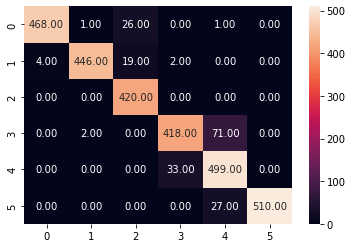

In [43]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')